In [1]:
import uhd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

ModuleNotFoundError: No module named 'uhd'

In [ ]:

usrp = uhd.usrp.MultiUSRP()

num_samps = 200000 # number of samples received
center_freq = 2.4e9 # Hz
sample_rate = 48e6 # Hz twice the BW
Fs = sample_rate
gain = 0# dB

usrp.set_rx_rate(sample_rate, 0)
usrp.set_rx_freq(uhd.libpyuhd.types.tune_request(center_freq), 0)
usrp.set_rx_gain(gain, 0)

In [ ]:
# Set up the stream and receive buffer
st_args = uhd.usrp.StreamArgs("fc32", "sc16")
st_args.channels = [0]
metadata = uhd.types.RXMetadata()
streamer = usrp.get_rx_stream(st_args)
recv_buffer = np.zeros((1, 1000), dtype=np.complex64)

# Start Stream
stream_cmd = uhd.types.StreamCMD(uhd.types.StreamMode.start_cont)
stream_cmd.stream_now = True
streamer.issue_stream_cmd(stream_cmd)

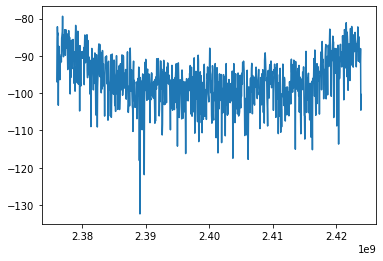

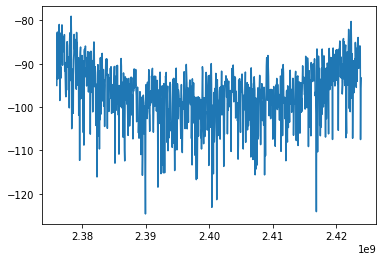

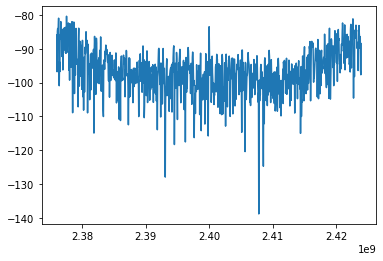

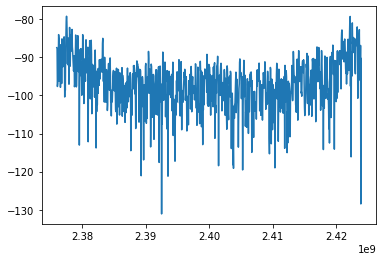

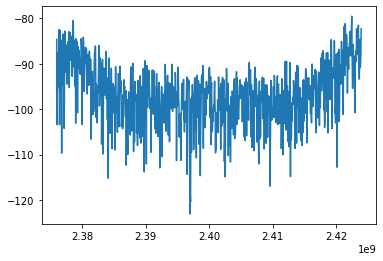

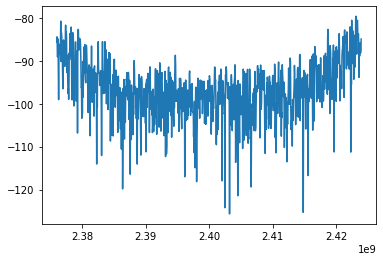

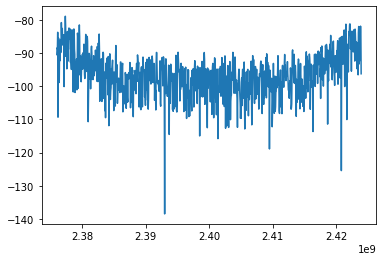

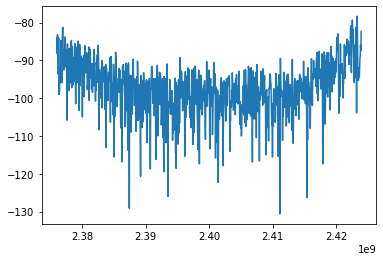

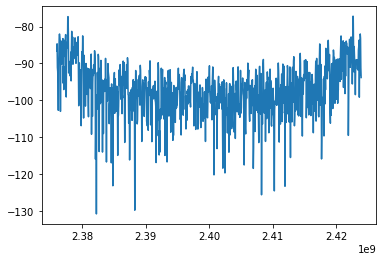

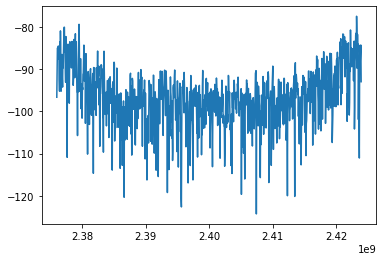

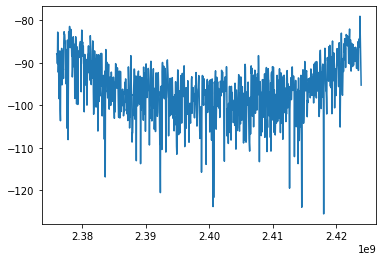

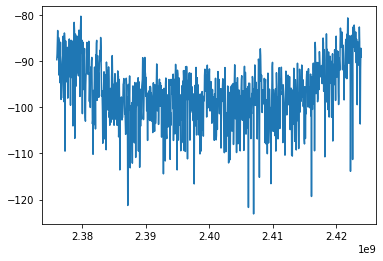

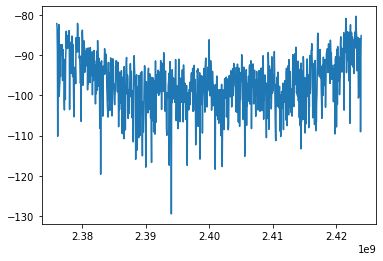

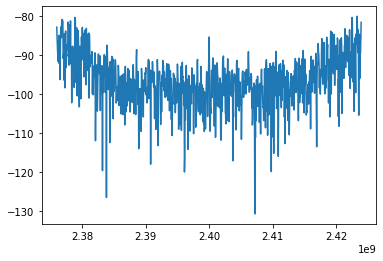

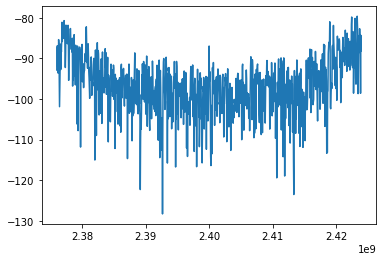

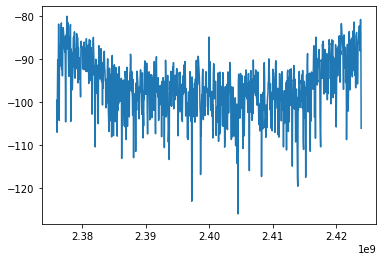

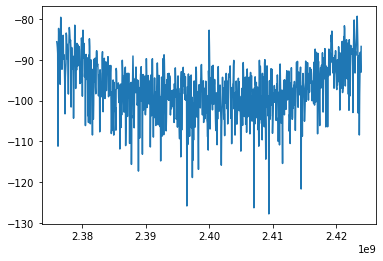

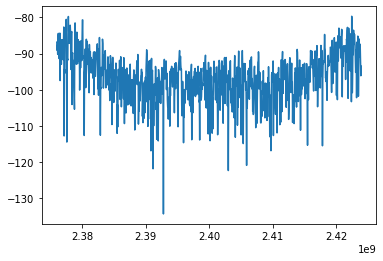

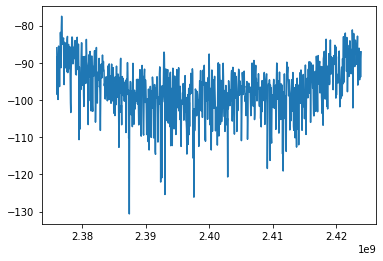

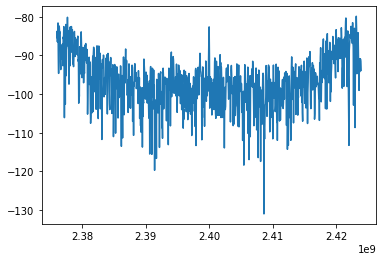

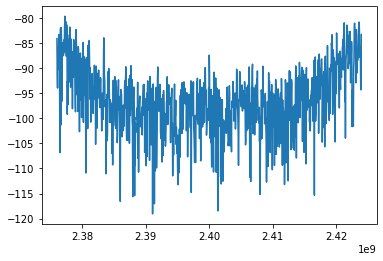

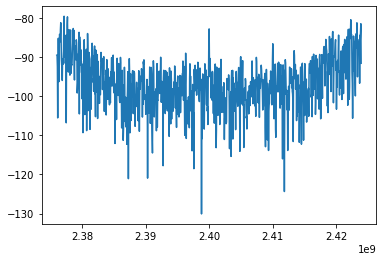

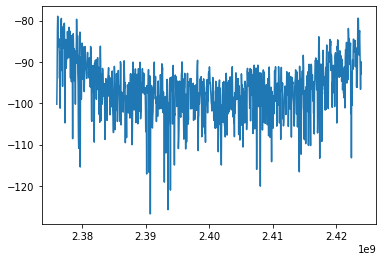

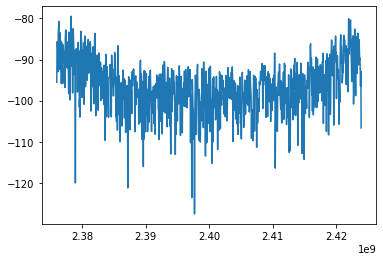

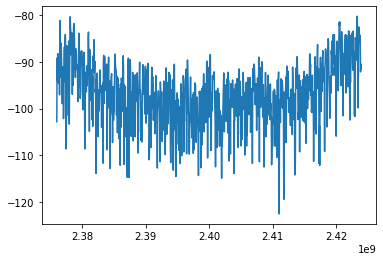

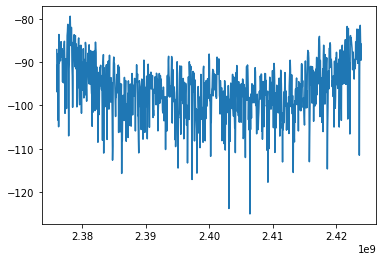

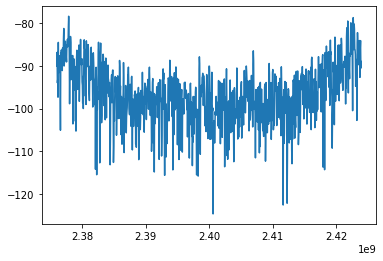

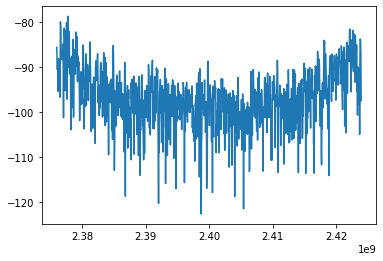

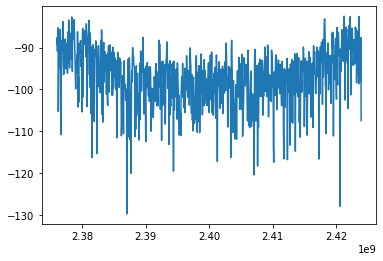

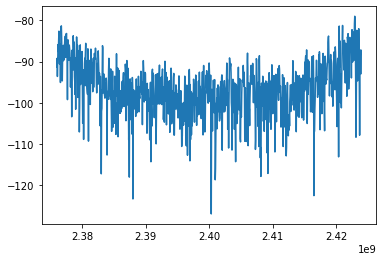

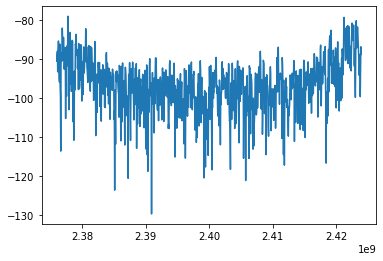

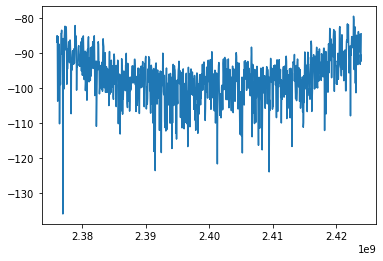

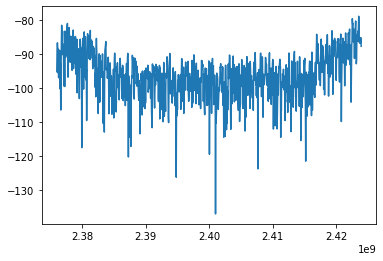

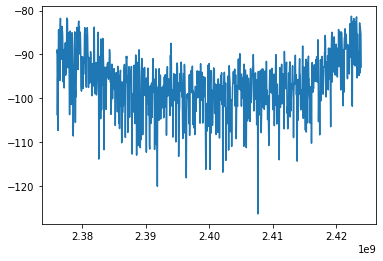

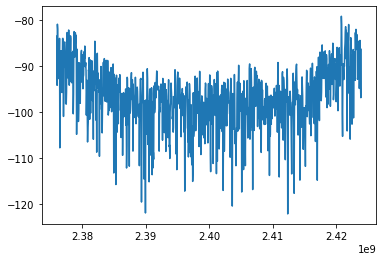

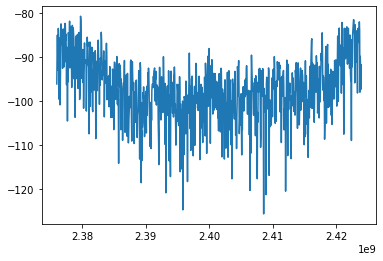

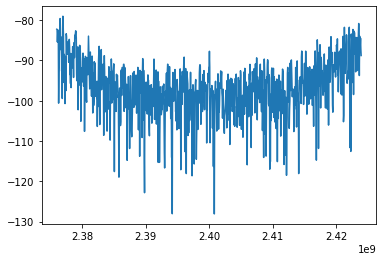

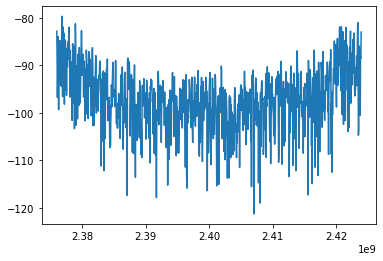

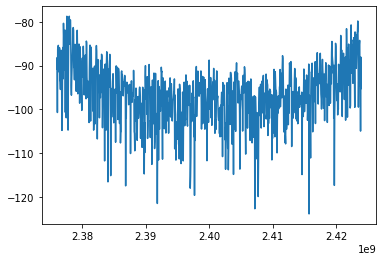

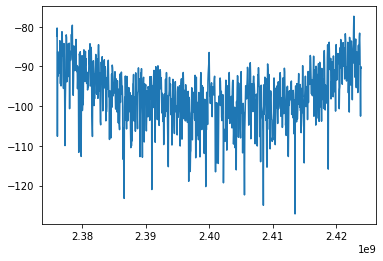

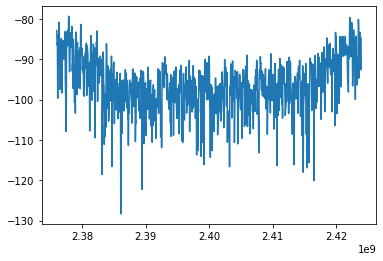

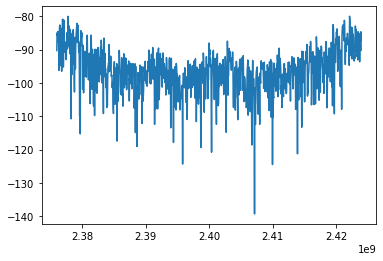

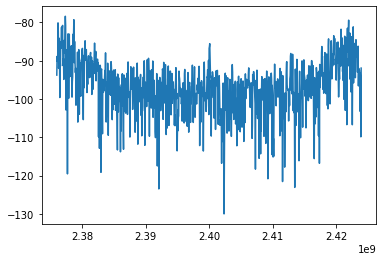

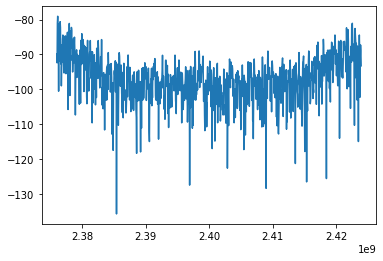

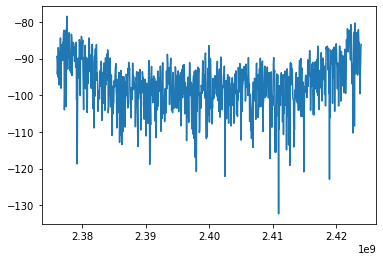

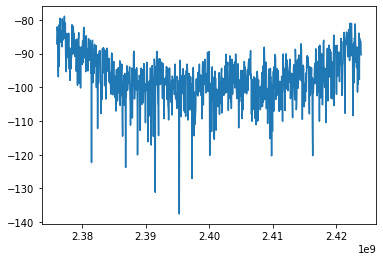

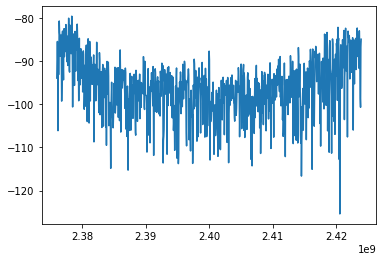

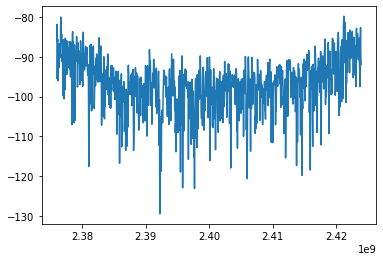

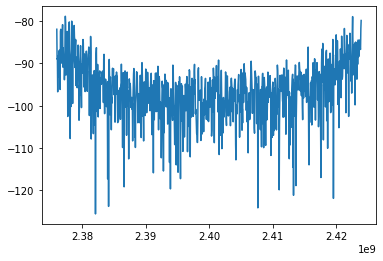

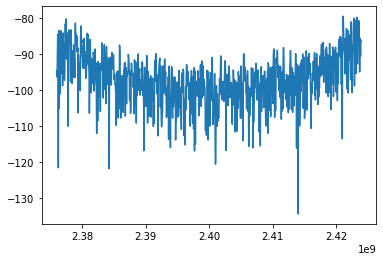

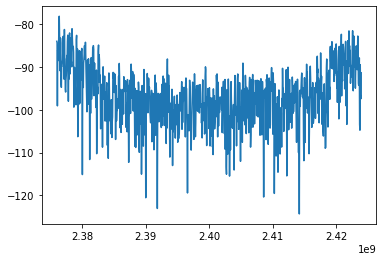

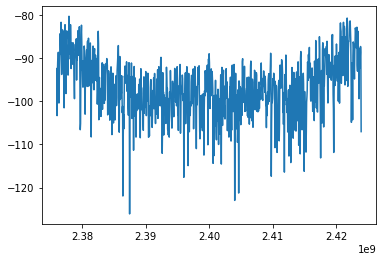

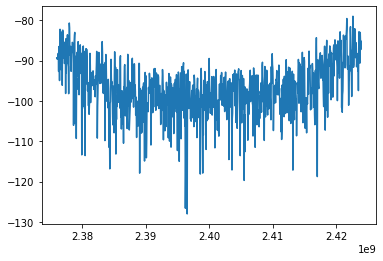

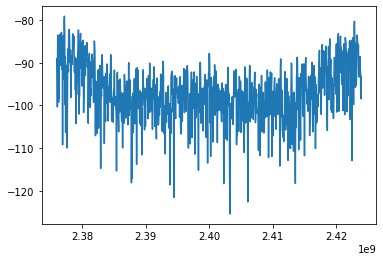

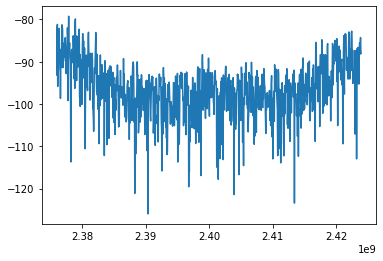

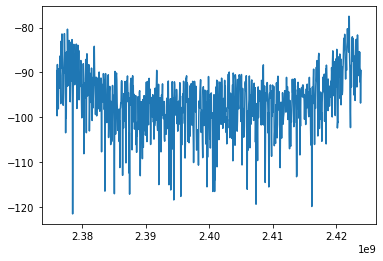

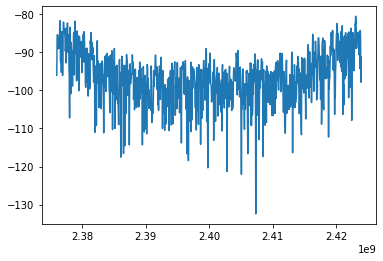

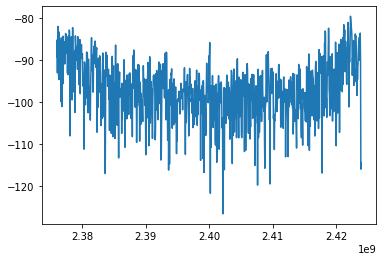

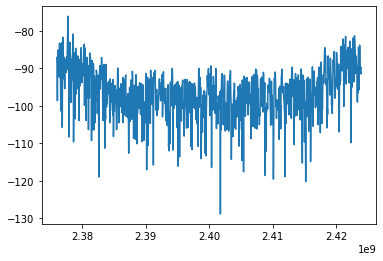

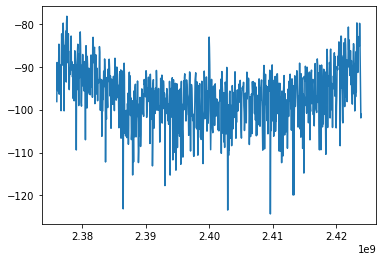

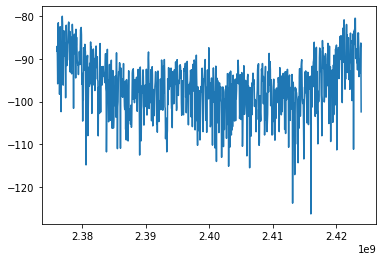

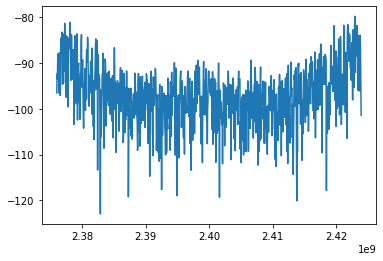

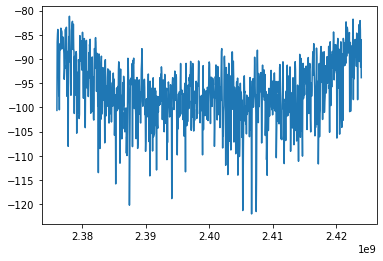

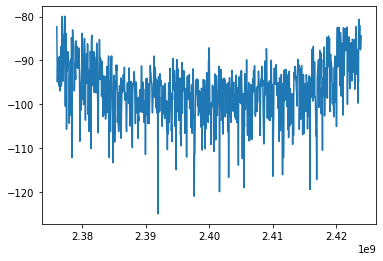

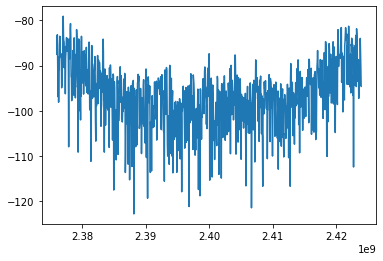

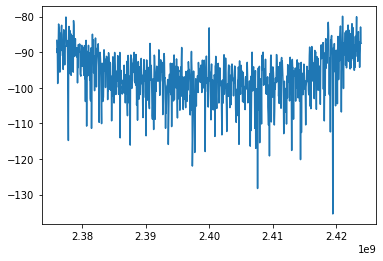

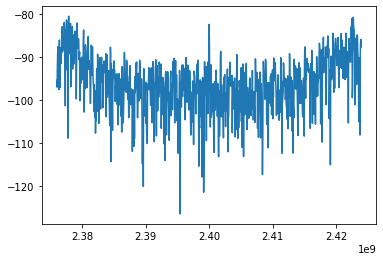

O

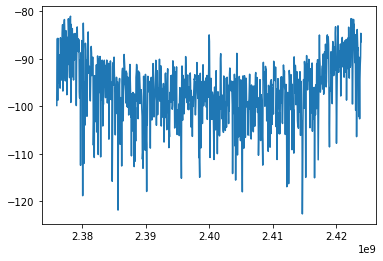

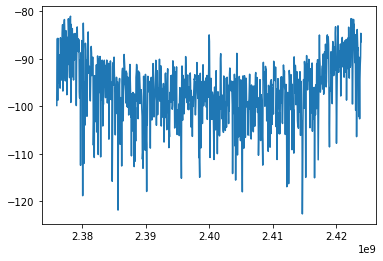

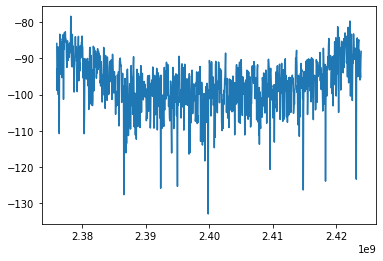

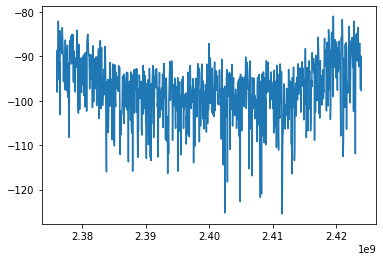

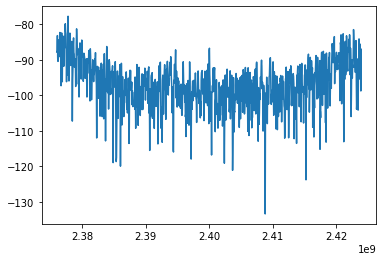

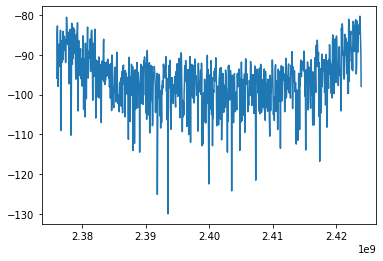

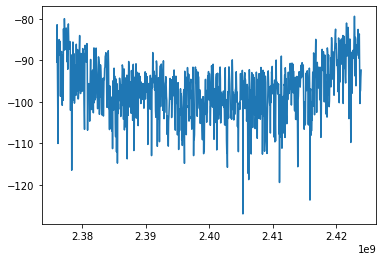

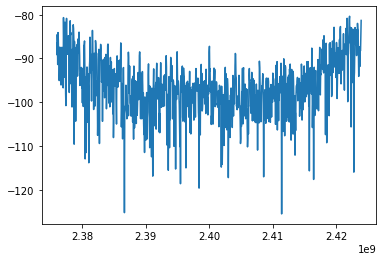

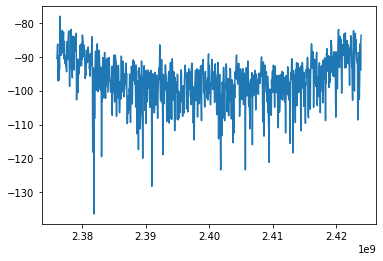

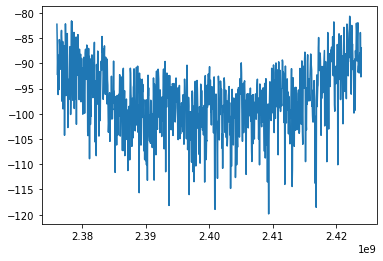

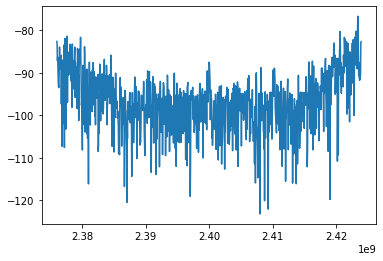

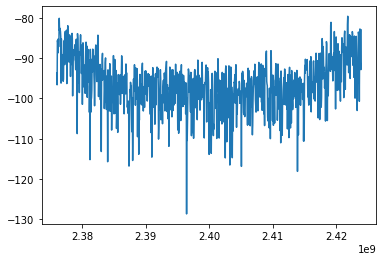

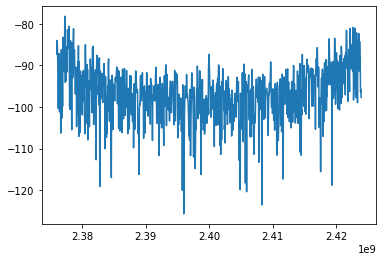

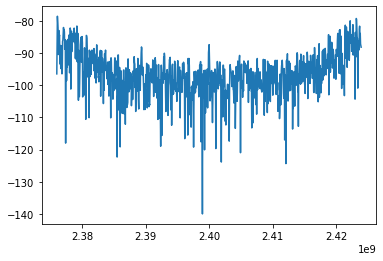

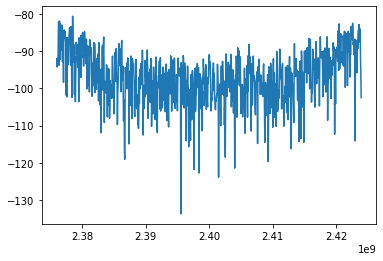

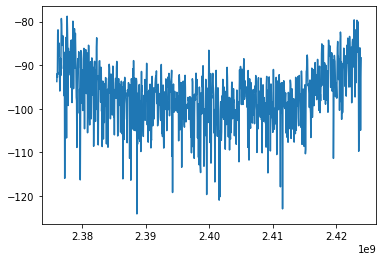

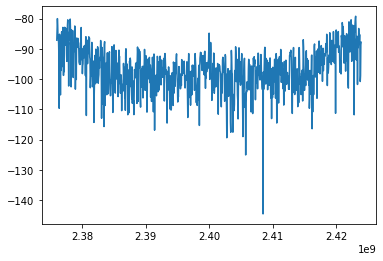

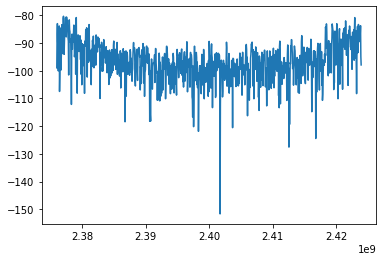

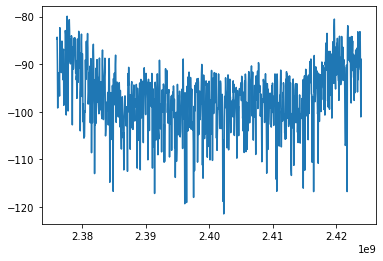

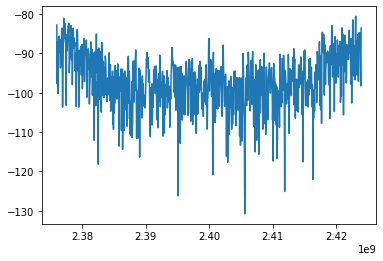

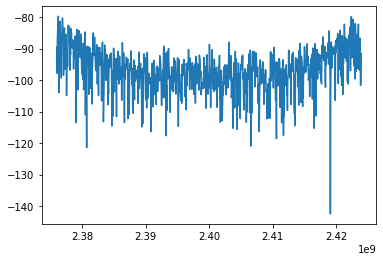

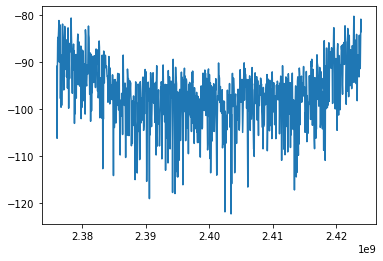

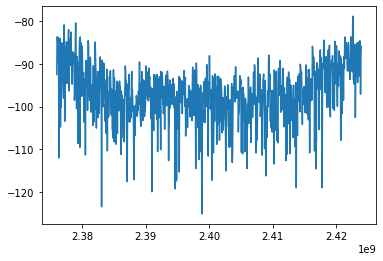

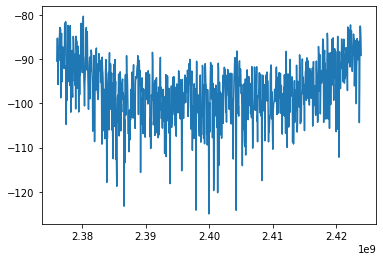

KeyboardInterrupt: 

In [ ]:
# Receive Samples
samples = np.zeros(num_samps, dtype=np.complex64)
captures = 1000
for i in range(num_samps//captures):
    streamer.recv(recv_buffer, metadata)
    samples = recv_buffer[0]
    x = samples * np.hamming(len(samples)) 
    PSD = (np.abs(np.fft.fft(x))/captures)**2
    PSD_log = 10.0*np.log10(PSD)
    PSD_shifted = np.fft.fftshift(PSD_log)
    
    
    f = np.arange(Fs/-2.0, Fs/2.0, Fs/captures) # start, stop, step.  centered around 0 Hz
    f += center_freq # now add center frequency
    plt.plot(f, PSD_shifted)
    plt.show()
    # plt.plot(10*np.log10(abs(samples)))
    # plt.show()

# Stop Stream
stream_cmd = uhd.types.StreamCMD(uhd.types.StreamMode.stop_cont)
streamer.issue_stream_cmd(stream_cmd)



N= 1024
x = samples[0:N] # we will only take the FFT of the first 1024 samples, see text below
